<a href="https://colab.research.google.com/github/hepham/graduation_thesis/blob/main/ANN_using_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from functools import reduce
import requests
import keras
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
path_train='/content/gdrive/MyDrive/datakltn/datatest.csv'
path_test='/content/gdrive/MyDrive/datakltn/area0/test.csv'

Mounted at /content/gdrive


In [3]:
data_train=pd.read_csv(path_train)
data_test=pd.read_csv(path_test)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48600 entries, 0 to 48599
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Position Label  48600 non-null  int64
 1   Beacon1         48600 non-null  int64
 2   RSSI1           48600 non-null  int64
 3   Beacon2         48600 non-null  int64
 4   RSSI2           48600 non-null  int64
 5   Beacon3         48600 non-null  int64
 6   RSSI3           48600 non-null  int64
 7   Beacon4         48600 non-null  int64
 8   RSSI4           48600 non-null  int64
 9   Beacon5         48600 non-null  int64
 10  RSSI5           48600 non-null  int64
 11  Beacon6         48600 non-null  int64
 12  RSSI6           48600 non-null  int64
 13  Beacon7         48600 non-null  int64
 14  RSSI7           48600 non-null  int64
 15  Beacon8         48600 non-null  int64
 16  RSSI8           48600 non-null  int64
 17  Beacon9         48600 non-null  int64
 18  RSSI9           48600 non-

In [4]:
data_train.head()
print("shape:",data_train.shape)
data_train=data_train.abs()
data_test=data_test.abs()

shape: (48600, 21)


In [5]:
class Layer:
    def __init__(self):
        self.weights = np.zeros(shape=(input.shape[1],80))
        bias = np.zeros(shape=(80,)) 
        pass
    
    def forward(self, input):
        output = np.matmul(input, self.weights) + bias
        return output

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.005):
        self.learning_rate = learning_rate
        
        # weight là ma trận có số cột = input số hàng là output
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    #hàm forward: f_l=w*f_(l-1)+bias
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
      
    def backward(self,input,grad_output):
      # đạo hàm df/dx,df/dw,df/d_bias
        df = np.dot(grad_output,np.transpose(self.weights))
        dw = np.transpose(np.dot(np.transpose(grad_output),input))
        dbias = np.sum(grad_output, axis = 0)
        # Xuống đồi bằng đạo hàm:
        self.weights = self.weights - self.learning_rate * dw
        self.biases = self.biases - self.learning_rate * dbias
        return df
    def getname(self):
      print("Dense ",len(self.weights),len(self.weights[0]))

In [7]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return np.maximum(0,input)

    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad 
    def getname(self):
      print("Relu")

In [8]:
class crossEntropy:  
  @staticmethod
  def softmax(p,y):
    return np.exp(p[y])/np.sum(np.exp(p))
  def forward(self,p,y):
    crossEntropy=[]
    for i in range(len(p)):
      softmaxvalue=self.softmax(p[i],y[i])
      crossEntropy.append(-np.log(softmaxvalue))    
    return crossEntropy
  def crossEntropy(self,p,y):
    crossEntropy=[]
    for i in range(len(p)):
      softmaxvalue=self.softmax(p[i],y[i])
      crossEntropy.append(-np.log(softmaxvalue))    
    return crossEntropy
  def backward(self,y_pred,y_true):
    ones_hot = np.zeros_like(y_pred)
    ones_hot[np.arange(len(y_pred)),y_true] = 1
    softmax = np.exp(y_pred) / np.exp(y_pred).sum(axis=-1,keepdims=True)
    return (- ones_hot + softmax) / y_pred.shape[0]

In [9]:
def load_dataset(flatten=False):
    feature = ['Position Label']
    train_feature =data_train.drop(feature, axis=1)
    # Set The Target
    train_target = data_train["Position Label"]
    # Split Data
    from sklearn.model_selection import train_test_split, cross_val_score
    X_train, X_test, y_train, y_test = train_test_split(train_feature ,train_target, test_size=0.3, random_state=42)
    X_train=X_train.to_numpy()
    X_test=X_test.to_numpy()
    y_train=y_train.to_numpy()
    y_test = y_test .to_numpy()
    return X_train, X_test, y_train, y_test
X_train, X_test,y_train, y_test = load_dataset()

In [ ]:
class MLP:
  def __init__(self,input,hiddens,activation="relu"):
    self.input=input
    self.hiddens=hiddens
    self.network=[] 
    self.network.append(Dense(input,hiddens[0]))
    self.network.append(ReLU())
    for i in range(len(hiddens)-2):
      self.network.append(Dense(hiddens[i],hiddens[i+1]))
      self.network.append(ReLU())
    self.network.append(Dense(hiddens[len(hiddens)-2],hiddens[len(hiddens)-1]))
    # for i in self.network:
    #   print(i.name())

  def forward(self,X):
      activations = []
      input = X
      for i in range(len(self.network)):
          activations.append(self.network[i].forward(X))
          X = self.network[i].forward(X)
          
      assert len(activations) == len(self.network)
      return activations

  def predict(self,X):
      y_pred = self.forward(X)[-1]
      return y_pred.argmax(axis=-1)

  def train(self,X,y):
      layer_activations = self.forward(X)
      y_pred = layer_activations[-1]
      derivation=crossEntropy()
      loss =derivation.forward(y_pred,y)
      loss_grad = derivation.backward(y_pred,y)
      
      for i in range(1, len(self.network)):
          loss_grad = self.network[len(self.network) - i].backward(layer_activations[len(self.network) - i - 1], loss_grad)
      
      return np.mean(loss)

In [22]:
from tqdm import trange
import logging
logging.info("hello world")
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs)) 
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

epoch 999 ,train_loss 0.2465 ,acc_training 0.9068 ,acc_testing 0.8882
Acurracy training and testing


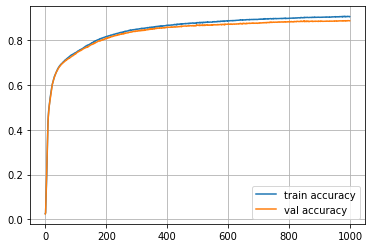

LOSS value


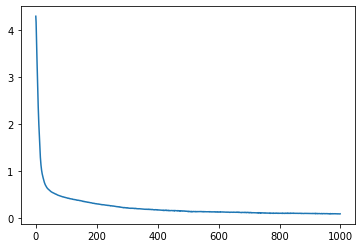

Accuracy train: 0.9084362139917695
Accuracy test: 0.8888203017832648
Loss: 0.08874370107853768


In [37]:
train_log = []
val_log = []
loss_log=[]
model=MLP(input=X_train.shape[1],hiddens=[1024,512,80])
for epoch in range(1000):
    loss_train=[]  
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=64,shuffle= False):n 
        loss=model.train(x_batch,y_batch) 
        loss_train.append(loss)
    loss_log.append(min(loss_train))
    acurateTraining=np.mean(model.predict(X_train)==y_train)
    train_log.append(acurateTraining)
    acurateTesting=np.mean(model.predict(X_test)==y_test)
    val_log.append(acurateTesting)
    clear_output()
    print('epoch ' + str(epoch) + ' ,train_loss ' + str((round(loss,4))) + ' ,acc_training ' + str(round(acurateTraining,4)) + ' ,acc_testing ' + str(round(acurateTesting,4)))
print("Acurracy training and testing")
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
print("LOSS value")
plt.plot(loss_log,label="Loss")
plt.show()
print("Accuracy train:",max(train_log))
print("Accuracy test:",max(val_log))
print("Loss:",min(loss_log))